<div style="color:yellow;text-align:center;font-weight:bolder;font-size:1.5em;background-color: black;">

# Fuentes

</div>

## Dataset

Fuente de los datos: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data<br>

Este dataset publicado por IBM Cognos Analytics ([original](https://community.ibm.com/community/user/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)) organiza la información de clientes, donde cada fila corresponde a un cliente individual y cada columna detalla sus atributos.

Incluye la siguiente información:

* **Churn:** Indica si el cliente ha **caído del servicio** en el último mes. Es decir, si el cliente ha causado baja.
* **Servicios contratados:** Detalles sobre los servicios a los que cada cliente está suscrito, como teléfono, varias líneas, internet, seguridad en línea, almacenamiento en la nube, protección de dispositivos, soporte técnico y servicios de streaming (TV y películas).
* **Información de la cuenta:** Datos como la antigüedad del cliente, tipo de contrato, método de pago, facturación electrónica, cargos mensuales y cargos totales.
* **Información demográfica:** Características del cliente como género, rango de edad, si tienen pareja y si tienen dependientes.

### Problema de Clasificación

El reto se formula como un problema de **clasificación binaria**: para cada cliente vamos a predecir si abandonará el servicio (“Churn = Yes”) o permanecerá (“Churn = No”). Al disponer ya de un histórico etiquetado, lo normal es enfocarlo desde el **aprendizaje supervisado**, donde entrenaremos distintos modelos sobre ejemplos con su resultado real y evaluaremos su capacidad de generalizar. Métricas como el AUC-ROC, la precisión, el recall o el F1-score nos permitirán comparar objetivamente los candidatos y elegir el más robusto para el negocio.

De manera complementaria, aplicaremos también **técnicas no supervisadas** para descubrir segmentos de clientes con patrones de comportamiento similares, que permitan a Negocio obtener quizás puntos de vista nuevos hacia los datos y puedan diseñar campañas o productos que ayuden a fidelizar clientes.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Entendiendo el Dataset

### Exploración inicial

In [8]:
df = pd.read_csv('..\\data\\raw\\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
for i in df.columns:
    if df[i].nunique() < 10:
        print('Columna:', i)
        print(df[i].unique())

Columna: gender
['Female' 'Male']
Columna: SeniorCitizen
[0 1]
Columna: Partner
['Yes' 'No']
Columna: Dependents
['No' 'Yes']
Columna: PhoneService
['No' 'Yes']
Columna: MultipleLines
['No phone service' 'No' 'Yes']
Columna: InternetService
['DSL' 'Fiber optic' 'No']
Columna: OnlineSecurity
['No' 'Yes' 'No internet service']
Columna: OnlineBackup
['Yes' 'No' 'No internet service']
Columna: DeviceProtection
['No' 'Yes' 'No internet service']
Columna: TechSupport
['No' 'Yes' 'No internet service']
Columna: StreamingTV
['No' 'Yes' 'No internet service']
Columna: StreamingMovies
['No' 'Yes' 'No internet service']
Columna: Contract
['Month-to-month' 'One year' 'Two year']
Columna: PaperlessBilling
['Yes' 'No']
Columna: PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Columna: Churn
['No' 'Yes']


#### Target / Variable Objetivo:
- **Churn**: Indica si el cliente de esta empresa de telecomunicaciones causó baja en el último mes (Sí/No).

#### Características:
-   **customerID**: Identificador único de cada cliente.
-   **gender**: Indica si el cliente es hombre o mujer.
-   **SeniorCitizen**: Especifica si el cliente es una persona de la tercera edad (1 para sí, 0 para no).
-   **Partner**: Indica si el cliente tiene pareja (Sí/No).
-   **Dependents**: Indica si el cliente tiene personas dependientes a su cargo (Sí/No).
-   **tenure**: El número de meses que el cliente ha permanecido con la empresa.
-   **PhoneService**: Indica si el cliente tiene servicio telefónico (Sí/No).
-   **MultipleLines**: Indica si el cliente tiene múltiples líneas (Sí, No o Sin servicio telefónico).
-   **InternetService**: El proveedor de servicio de internet del cliente (DSL, Fibra óptica o No).
-   **OnlineSecurity**: Indica si el cliente tiene seguridad online (Sí, No o Sin servicio de internet).
-   **OnlineBackup**: Indica si el cliente tiene servicio de backup online (Sí, No o Sin servicio de internet).
-   **DeviceProtection**: Indica si el cliente tiene protección de dispositivo (Sí, No o Sin servicio de internet).
-   **TechSupport**: Indica si el cliente tiene soporte técnico (Sí, No o Sin servicio de internet).
-   **StreamingTV**: Indica si el cliente tiene servicio de TV por streaming (Sí, No o Sin servicio de internet).
-   **StreamingMovies**: Indica si el cliente tiene servicio de películas por streaming (Sí, No o Sin servicio de internet).
-   **Contract**: El tipo de contrato del cliente (Mensual, Un año o Dos años).
-   **PaperlessBilling**: Indica si el cliente tiene facturación sin papel (Sí o No).
-   **PaymentMethod**: El método de pago del cliente (Cheque electrónico, Cheque por correo, Transferencia bancaria (automática) o Tarjeta de crédito (automática)).
-   **MonthlyCharges**: El importe que se le cobra al cliente mensualmente.
-   **TotalCharges**: El importe total cobrado al cliente.

In [1]:
# Lista de las columnas con Yes / No (y otras opciones equiparables a No)
cols_yes_no = ['Churn', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Iteración sobre cada columna y aplica el mapeo
for col in cols_yes_no:
    df[col] = df[col].map({
        'Yes': 1,
        'No': 0,
        'No phone service': 0,
        'No internet service':0
        })
    
# Otras columnas similares
''''InternetService', 'Contract'
'''

df.head(3)

NameError: name 'df' is not defined

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   int64  


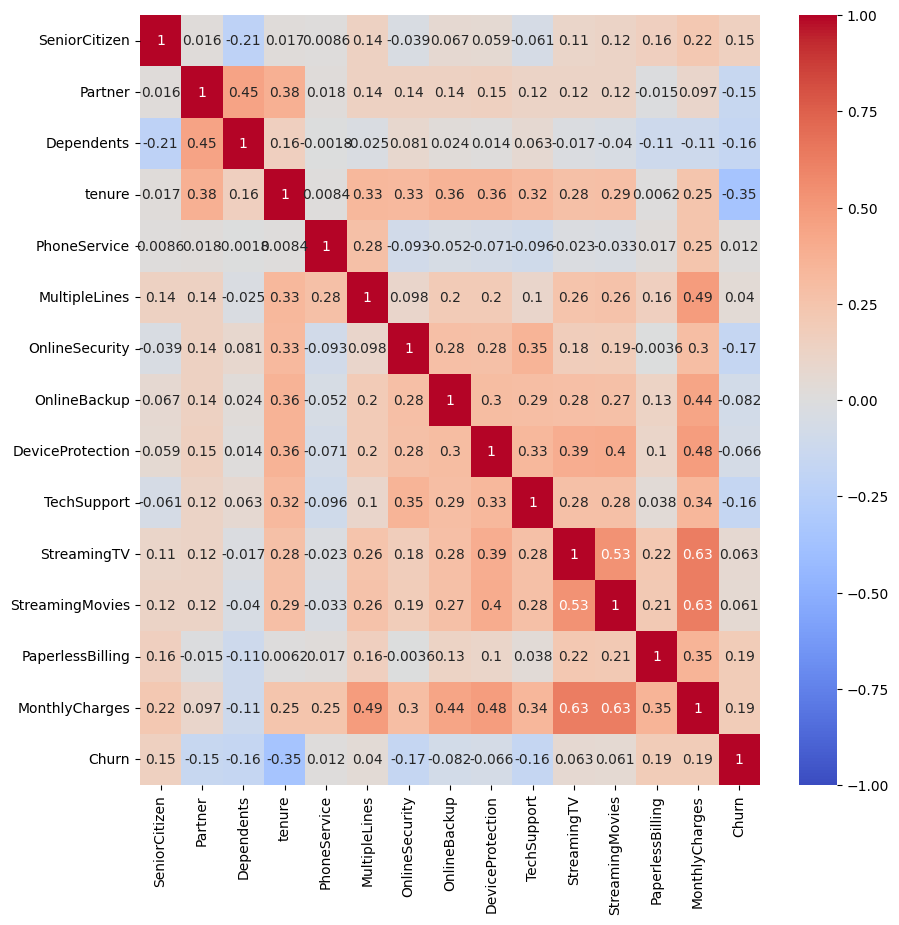

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(
    df.corr(numeric_only=True),
    vmin=-1,
    cmap = 'coolwarm',
    annot = True,
);

In [13]:
X = df[['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'OnlineSecurity', 'TechSupport', 'PaperlessBilling', 'MonthlyCharges']]
y = df['Churn']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state=10)

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators = 100,
    max_depth=3,
    max_features = 3,
    random_state = 10
)

scores = cross_val_score (
    rnd_clf,
    X,
    y,
    cv = 5,
    scoring = 'accuracy'
)

print('Baseline RandomForestClassifier:')
rnd_clf.fit(X_train, y_train)

pred = rnd_clf.predict(X_test)

rtdo_random_forest = accuracy_score(y_test, pred)
print(rtdo_random_forest)

Baseline RandomForestClassifier:
0.7934705464868701
